## Introduction

The impacts of climate change are being felt more severely throughout the world today. The associated severe weather, drought, and fires that are the results of climate change are threatening food production in countries around the world. According to the United Nations, the overall growth of wheat, maize, and other crops is declining as a result of extreme weather events and high temperatures causing severe drought.

The scope of our project is to analyze the impacts that Climate change has on Global Food Supply. Our team is seeking to understand how climate change affects global food supply and how countries that are most affected by this, can leverage the data to find feasible solutions to combat the shortage. 

To further expand our EDA process, we narrowed down which datasets needed to be merged and analyzed to answer questions the team brainstormed together. Some of the questions we were seeking to answer: 

* Which countries are most impacted by extreme weather events?

* Which countries are top producers of cereals and grains?

* How has the total population trended, per country?

* What countries are most dependent on agriculture for their economy? (GDP)

* How much of their agricultural land decreased over time?

* Which countries are most dependent on food imports?

* What are the top countries receiving food aid?

* What are the top countries contributing to climate change?  

We decided which features would be needed to build a simple linear regression model to predict food production. The team's approach was to combine all relevant datasets (disaster frequency, crop production, country and year, food aid) together and examine the correlation with each column in the combined dataset to determine if any trends were present. We continued to build on the insights we gained from our initial EDA to find the correlation between climate change and the impact that it has on the global food supply and have a great understanding of which countries are impacted the mosted and why.   


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr
%matplotlib inline

In [ ]:
climate_disaster = '/content/drive/MyDrive/Data/Climate_Disaster_Data/24_Climate-related_Disasters_Frequency.csv'
climate_disaster_df = pd.read_csv(climate_disaster)
climate_disaster_df.drop(columns=['Country','ISO2','Source','CTS Code', 'CTS Full Descriptor','Unit','CTS Name','Climate Influence'], inplace=True)
climate_disaster_df['Indicator'] = climate_disaster_df['Indicator'].str.split(',|:',expand=True)[2].str.strip()
climate_disaster_df = climate_disaster_df[climate_disaster_df['Indicator'] != 'TOTAL']
climate_disaster_df = pd.melt(climate_disaster_df, id_vars=['ISO3','Indicator'],var_name='Year', value_name='Frequency')

null_count = climate_disaster_df['Frequency'].isnull().groupby(climate_disaster_df['Year']).sum()
total_count = climate_disaster_df['Frequency'].groupby(climate_disaster_df['Year']).count()
climate_disaster_df['Frequency'].fillna(0, inplace=True)
climate_disaster_df['Year']= climate_disaster_df['Year'].astype('int64')

It's better to replace null with `0` by EAD defination of climate disaster:
- Killed ten (10) or more people 
- Affected hundred (100) or more people 
- Led to declaration of a state of emergency
- Led to call for international assistance  

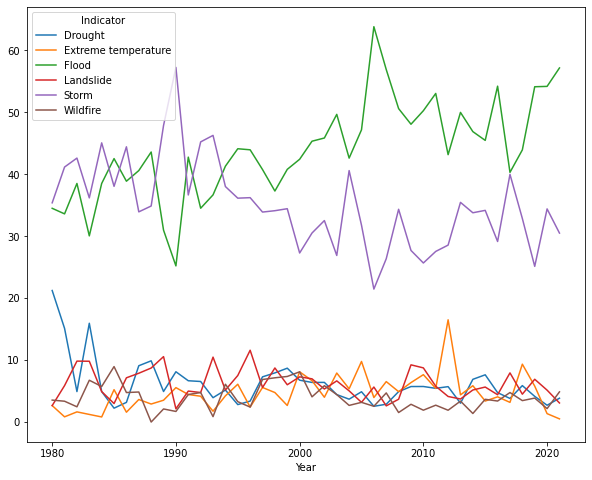

In [ ]:
t = climate_disaster_df.groupby(['Year','Indicator'])['Frequency'].sum().to_frame().reset_index().pivot_table(index='Year', columns='Indicator',values='Frequency',aggfunc='sum')

t['Total'] = t.apply(lambda row: row.sum(), axis=1)


df_percentage = t.div(t['Total'], axis=0).mul(100)


df_percentage.drop(columns='Total').plot.line(figsize=(10,8))

The proportion of Flood as the cause of a disaster started around the mid 2000's at the same time when disasters overall increased. 
- Flood seems to be correlated with storms. Will this occur at the same year and same country?
- Landslide, Extreme temperatures and Wildfires seems to have little to no change in the last 40 year

Correlation between the log of storms and flodds: 0.40616118748340746 



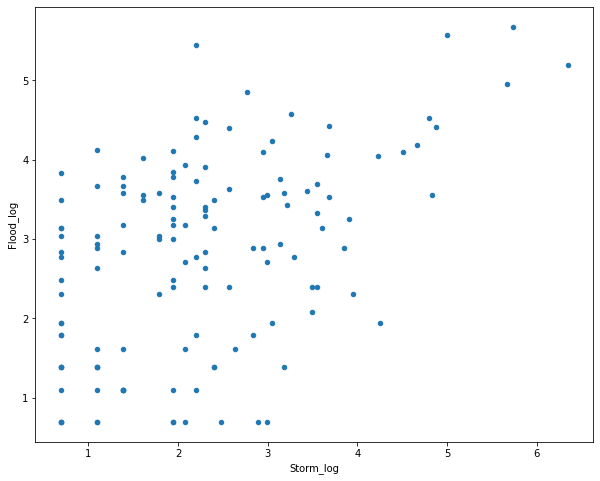

In [ ]:
storms_floods = climate_disaster_df[climate_disaster_df['Indicator'].isin(['Flood','Storm'])]
table_srm_flds = pd.pivot_table(storms_floods,values='Frequency',index=['ISO3','Year'], columns='Indicator', aggfunc=np.sum).reset_index()

strm_flds_by_country = table_srm_flds.reset_index()[['ISO3','Flood','Storm']].groupby('ISO3').sum().reset_index()
strm_flds_by_year = table_srm_flds.reset_index()[['Year','Flood','Storm']].groupby('Year').sum().reset_index()

strm_flds_by_country['Flood_log'] = strm_flds_by_country.apply(lambda x: np.emath.log(x['Flood']) if x['Flood'] > 0 else 0, axis=1)
strm_flds_by_country['Storm_log'] = strm_flds_by_country.apply(lambda x: np.emath.log(x['Storm']) if x['Storm'] > 0 else 0, axis=1)

strm_flds_by_country[(strm_flds_by_country['Flood_log'] > 0)  & (strm_flds_by_country['Storm_log'] > 0)].plot.scatter(x='Storm_log',y='Flood_log',figsize=(10,8))




r_sq, p = pearsonr(strm_flds_by_country['Storm_log'],strm_flds_by_country['Flood_log'])

print(f'Correlation between the log of storms and flodds: {r_sq} \n')

The correlation between Storms and floods sugest that the observed increased intensity of storms will lead to more flooding in the future. Data paired by country

Correlation between the log of storms and flodds: 0.656837367522172 



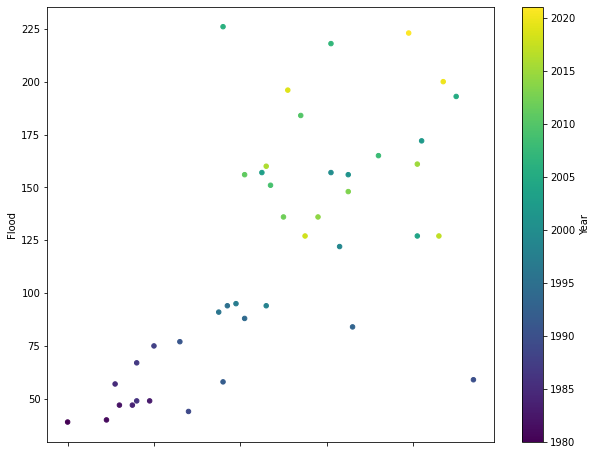

In [ ]:
r_sq, p = pearsonr(strm_flds_by_year['Storm'],strm_flds_by_year['Flood'])

strm_flds_by_year.plot.scatter(x='Storm',y='Flood',c='Year',colormap='viridis',figsize=(10,8))
print(f'Correlation between the log of storms and flodds: {r_sq} \n')

When grouped by year, we see the same type of corralation, although stronger. More storms are being registered as the cause of a disaster, and at the same time more floodings are occurring.

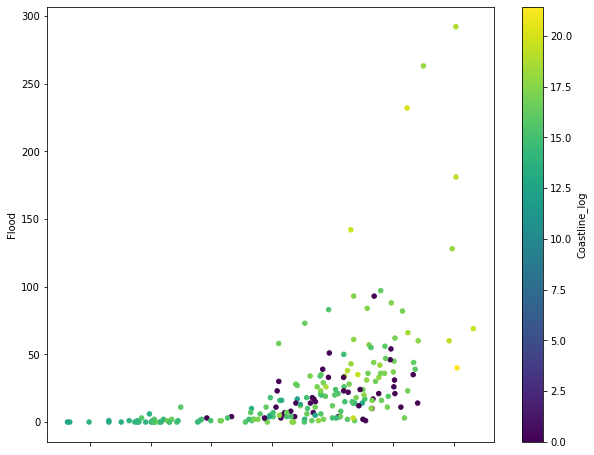

In [ ]:
country_info = pd.read_csv('/content/drive/MyDrive/Data/Cleaned_Datasets/General/country_information.csv')
climate_disaster_exp = climate_disaster_df.merge(country_info,how='inner',left_on='ISO3',right_on='ISO3')

climate_disaster_exp['Coastline_log'] = climate_disaster_exp.apply(lambda x: np.emath.log(x['Coastline'] * x['Area']*100) if x['Coastline'] > 0 else 0,axis=1)
climate_disaster_exp['Area_log'] = climate_disaster_exp.apply(lambda x: np.emath.log(x['Area']) ,axis=1)

storms_floods = climate_disaster_exp[['ISO3','Area_log','Coastline_log','Indicator','Frequency','Year','Region']][
            (climate_disaster_exp['Indicator'].isin(['Flood','Storm'])) & (climate_disaster_exp['Year'] >= 1980)
            ]

table_srm_flds = pd.pivot_table(storms_floods,values='Frequency',index=['ISO3','Year','Area_log','Coastline_log','Region'], columns='Indicator', aggfunc=np.sum).reset_index()

aggregation = {'Area_log':'mean', 'Coastline_log':'mean','Flood':'sum','Storm':'sum'}

dis_country_area = table_srm_flds.groupby(['ISO3','Region'],as_index=False).agg(aggregation)

dis_country_area.plot.scatter(x='Area_log', y='Flood',c='Coastline_log',colormap='viridis',figsize=(10,8))

Flooding disasters occurs more often in countries with a larger area, no surprisingly. 
Coastline is not a big predictor of flooding disasters ocurring, because a large proportion occurs in countries with short coastlines and large areas

In [ ]:
group_table = dis_country_area[(dis_country_area['Coastline_log'] == 0) & (dis_country_area['Flood']>0)].groupby(['Region','ISO3']).sum('Flood').reset_index()
lookup = dis_country_area[(dis_country_area['Coastline_log'] == 0) & (dis_country_area['Flood']>0)].groupby(['Region'])['Flood'].nlargest(1).to_frame().reset_index().drop(columns='level_1').reset_index()

group_table.merge(lookup,how='inner',left_on=['Region','Flood'],right_on=['Region','Flood']).sort_values('Flood',ascending=False).to_html()

'<table border="1" class="dataframe">\n  <thead>\n    <tr style="text-align: right;">\n      <th></th>\n      <th>Region</th>\n      <th>ISO3</th>\n      <th>Area_log</th>\n      <th>Coastline_log</th>\n      <th>Flood</th>\n      <th>Storm</th>\n      <th>index</th>\n    </tr>\n  </thead>\n  <tbody>\n    <tr>\n      <th>0</th>\n      <td>ASIA (EX. NEAR EAST)</td>\n      <td>AFG</td>\n      <td>13.380874</td>\n      <td>0.0</td>\n      <td>93.0</td>\n      <td>9.0</td>\n      <td>0</td>\n    </tr>\n    <tr>\n      <th>5</th>\n      <td>SUB-SAHARAN AFRICA</td>\n      <td>ETH</td>\n      <td>13.935182</td>\n      <td>0.0</td>\n      <td>54.0</td>\n      <td>0.0</td>\n      <td>5</td>\n    </tr>\n    <tr>\n      <th>3</th>\n      <td>LATIN AMER. &amp; CARIB</td>\n      <td>BOL</td>\n      <td>13.909529</td>\n      <td>0.0</td>\n      <td>46.0</td>\n      <td>2.0</td>\n      <td>3</td>\n    </tr>\n    <tr>\n      <th>1</th>\n      <td>C.W. OF IND. STATES</td>\n      <td>TJK</td>\n      <td

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>Region</th>
      <th>ISO3</th>
      <th>Area_log</th>
      <th>Coastline_log</th>
      <th>Flood</th>
      <th>Storm</th>
      <th>index</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>0</th>
      <td>ASIA (EX. NEAR EAST)</td>
      <td>AFG</td>
      <td>13.380874</td>
      <td>0.0</td>
      <td>93.0</td>
      <td>9.0</td>
      <td>0</td>
    </tr>
    <tr>
      <th>5</th>
      <td>SUB-SAHARAN AFRICA</td>
      <td>ETH</td>
      <td>13.935182</td>
      <td>0.0</td>
      <td>54.0</td>
      <td>0.0</td>
      <td>5</td>
    </tr>
    <tr>
      <th>3</th>
      <td>LATIN AMER. &amp; CARIB</td>
      <td>BOL</td>
      <td>13.909529</td>
      <td>0.0</td>
      <td>46.0</td>
      <td>2.0</td>
      <td>3</td>
    </tr>
    <tr>
      <th>1</th>
      <td>C.W. OF IND. STATES</td>
      <td>TJK</td>
      <td>11.871299</td>
      <td>0.0</td>
      <td>33.0</td>
      <td>2.0</td>
      <td>1</td>
    </tr>
    <tr>
      <th>6</th>
      <td>WESTERN EUROPE</td>
      <td>AUT</td>
      <td>11.337023</td>
      <td>0.0</td>
      <td>18.0</td>
      <td>19.0</td>
      <td>6</td>
    </tr>
    <tr>
      <th>2</th>
      <td>EASTERN EUROPE</td>
      <td>SRB</td>
      <td>11.389186</td>
      <td>0.0</td>
      <td>17.0</td>
      <td>0.0</td>
      <td>2</td>
    </tr>
    <tr>
      <th>4</th>
      <td>NEAR EAST</td>
      <td>PSE</td>
      <td>8.675905</td>
      <td>0.0</td>
      <td>4.0</td>
      <td>3.0</td>
      <td>4</td>
    </tr>
  </tbody>
</table>

In [ ]:
dis_country_area[(dis_country_area['Coastline_log'] == 0) & (dis_country_area['Flood']>0)].groupby('Region').median('Flood')['Flood'].sort_values(ascending=False)

Region
LATIN AMER. & CARIB                    35.0
ASIA (EX. NEAR EAST)                   23.0
SUB-SAHARAN AFRICA                     22.5
EASTERN EUROPE                         14.0
WESTERN EUROPE                          8.0
C.W. OF IND. STATES                     4.0
NEAR EAST                               4.0
Name: Flood, dtype: float64

Countries with more propensity to flooding without a coastline tend to be countries with usually worse infrastructure. Like Bolivia, Afghanistan  or Ethiopia

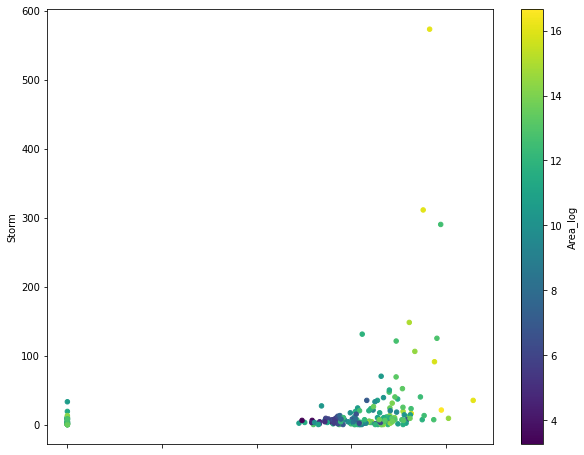

In [ ]:
dis_country_area.plot.scatter(x='Coastline_log', y='Storm',c='Area_log',colormap='viridis',figsize=(10,8))

In [ ]:
dis_country_area[(dis_country_area['Coastline_log'] == 0) & (dis_country_area['Storm']>0)].sort_values(by='Storm', ascending=False)

Indicator,ISO3,Region,Area_log,Coastline_log,Flood,Storm
31,CHE,WESTERN EUROPE,10.628376,0.0,8.0,33.0
11,AUT,WESTERN EUROPE,11.337023,0.0,18.0,19.0
120,MNG,ASIA (EX. NEAR EAST),14.262831,0.0,11.0,13.0
100,LAO,ASIA (EX. NEAR EAST),12.374971,0.0,23.0,11.0
46,CZE,EASTERN EUROPE,11.275505,0.0,14.0,10.0
29,CAF,SUB-SAHARAN AFRICA,13.342276,0.0,17.0,10.0
0,AFG,ASIA (EX. NEAR EAST),13.380874,0.0,93.0,9.0
108,LUX,WESTERN EUROPE,7.857868,0.0,3.0,9.0
147,PRY,LATIN AMER. & CARIB,12.915954,0.0,24.0,8.0
135,NPL,ASIA (EX. NEAR EAST),11.899418,0.0,51.0,8.0


Storms and Coastiline as expected are related to one another, countries with more coast will have a higher propensity to get storms. <br>
However countries with zero border with the sea will also have disasters related with Storm events. The definition in this dataset is loose and includes windstorms (Switserland ) and Sandstorms (Mongolia) among others

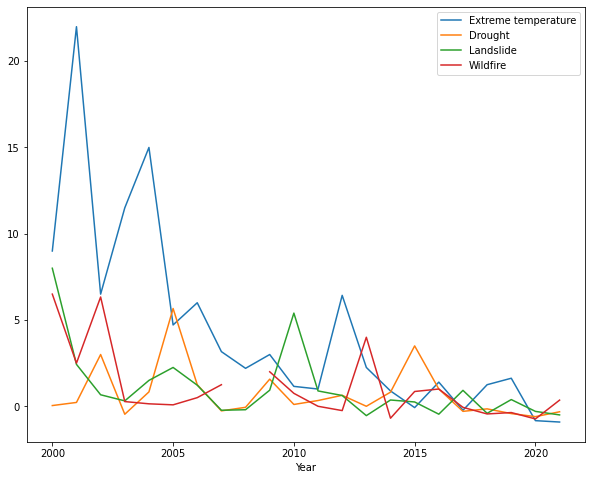

In [ ]:
disasters_by_indicator = climate_disaster_df.groupby(['Year','Indicator'])['Frequency'].sum().to_frame().reset_index().pivot_table(index='Year', columns='Indicator',values='Frequency',aggfunc='sum')
num_periods = 20
indicators = ['Extreme temperature','Drought','Landslide','Wildfire']
for indicator in indicators:
    disasters_by_indicator[indicator].pct_change(periods=num_periods).plot.line(legend=True,figsize=(10,8))

The rate of increase of the least significant climate disasters has been decreasing over 20 year periods. 
- There was a significant increase in Extreme temeprature disasters from 1980 to 2000, but the rate of change has stabilized over the last 20 years

In [ ]:
food_sec_dataset = '/content/drive/MyDrive/Data/Cleaned_Datasets/Food_Security_dataset.csv'
food_sec_dataset_df = pd.read_csv(food_sec_dataset)

In [ ]:
food_sec_dataset_df =food_sec_dataset_df[['ISO3','Year','TOTAL','Food Production (tonnes)']]

food_sec_dataset_df['Year']= food_sec_dataset_df['Year'].astype('int64')

In [ ]:
food_sec_dataset_df.groupby('ISO3').agg({'Food Production (tonnes)': lambda x: x.isnull().sum()}).sort_values(by='Food Production (tonnes)',ascending=False)



,Food Production (tonnes)
ISO3,
AFG,0
PAK,0
NCL,0
NER,0
NGA,0
...,...
GRC,0
GRD,0
GTM,0


In [ ]:
food_sec_dataset_df.dropna(inplace=True)

/usr/local/lib/python3.8/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [ ]:
food_by_year = food_sec_dataset_df.groupby('Year').sum()

food_by_year['food_prod_log'] = food_by_year.apply(lambda x: np.emath.log(x['Food Production (tonnes)']) ,axis=1)

In [ ]:
food_by_year.reset_index(inplace=True)

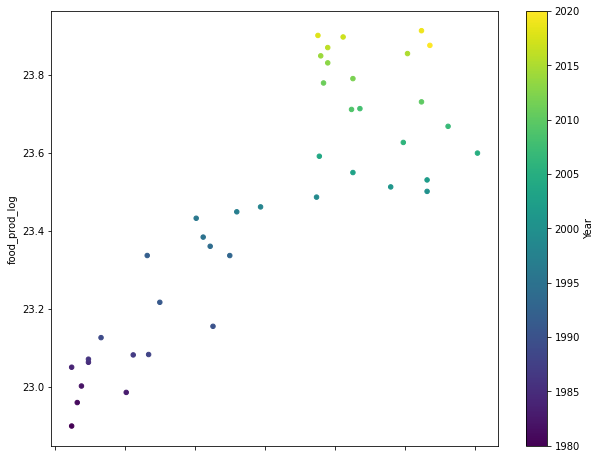

In [ ]:
food_by_year.plot.scatter(x='TOTAL', y='food_prod_log',c='Year',colormap='viridis',figsize=(10,8))

In [ ]:
food_by_countries = food_sec_dataset_df.groupby('ISO3').sum()
food_by_countries['food_prod_log'] = food_by_countries.apply(lambda x: np.emath.log(x['Food Production (tonnes)']) ,axis=1)
food_by_countries['total_log'] = food_by_countries.apply(lambda x: np.emath.log(x['TOTAL']) ,axis=1)
food_by_countries.reset_index(inplace=True)

Correlation between the log food production and total_disasters: 0.7530304554746452 



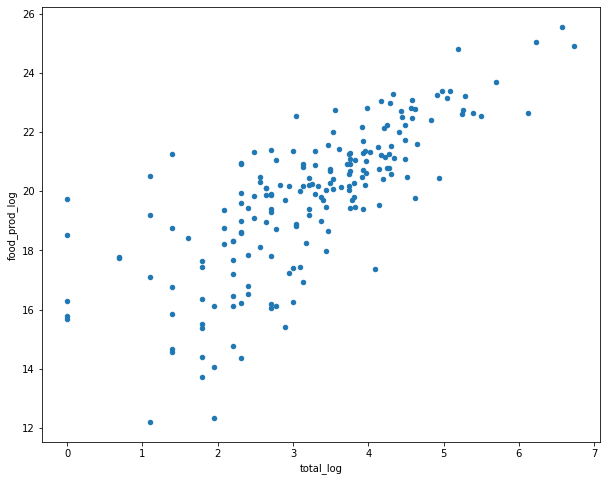

In [ ]:
r_sq, p = pearsonr(food_by_countries['total_log'],food_by_countries['food_prod_log'])
print(f'Correlation between the log food production and total_disasters: {r_sq} \n')

food_by_countries.plot.scatter(x='total_log', y='food_prod_log',figsize=(10,8))

In [ ]:
## Import Data folder from google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#General libraries imports and configurations
import numpy                 as np
import pandas                as pd
import matplotlib.pyplot     as plt
import seaborn               as sns

%matplotlib inline
sns.set()

pd.options.display.max_columns = 100
pd.options.display.max_rows = 100

In [ ]:
#Import the dataset
Food_Security_dataset = '/content/drive/MyDrive/Data/Cleaned_Datasets/Food_Security_dataset.csv'
Food_Security_dataset = pd.read_csv(Food_Security_dataset)
Food_Security_dataset.head()

,Unnamed: 0,ISO3,Year,Drought,Flood,Landslide,Storm,TOTAL,Wildfire,temperature,Country_y,Food Production (tonnes),Humanitarian and food aid received (2016 USD)
0,0,AFG,1980,0.0,1.0,0.0,0.0,1.0,0.0,0.0,Afghanistan,15008474.94,NaN
1,1,AFG,1981,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Afghanistan,14689422.04,NaN
2,2,AFG,1982,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Afghanistan,14247966.63,NaN
3,3,AFG,1983,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Afghanistan,13997995.78,NaN
4,4,AFG,1984,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Afghanistan,13465216.99,NaN


In [ ]:
# Display missing values
Food_Security_dataset[Food_Security_dataset.isnull().any(axis=1)]

,Unnamed: 0,ISO3,Year,Drought,Flood,Landslide,Storm,TOTAL,Wildfire,temperature,Country_y,Food Production (tonnes),Humanitarian and food aid received (2016 USD)
0,0,AFG,1980,0.0,1.0,0.0,0.0,1.0,0.0,0.0,Afghanistan,15008474.94,NaN
1,1,AFG,1981,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Afghanistan,14689422.04,NaN
2,2,AFG,1982,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Afghanistan,14247966.63,NaN
3,3,AFG,1983,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Afghanistan,13997995.78,NaN
4,4,AFG,1984,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Afghanistan,13465216.99,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9025,9025,ZWE,2017,1.0,0.0,NaN,1.0,2.0,NaN,NaN,Zimbabwe,15174437.37,NaN
9026,9026,ZWE,2018,0.0,0.0,NaN,0.0,0.0,NaN,NaN,Zimbabwe,16480902.92,NaN
9027,9027,ZWE,2019,0.0,1.0,NaN,1.0,2.0,NaN,NaN,Zimbabwe,13893945.11,NaN
9028,9028,ZWE,2020,0.0,0.0,NaN,0.0,0.0,NaN,NaN,Zimbabwe,15014247.89,NaN


In [ ]:
Food_Security_dataset.isnull().sum()

Unnamed: 0                                          0
ISO3                                                0
Year                                                0
Drought                                          3192
Flood                                            1344
Landslide                                        5544
Storm                                            1176
TOTAL                                               0
Wildfire                                         5628
temperature                                      5670
Country_y                                        1657
Food Production (tonnes)                         1657
Humanitarian and food aid received (2016 USD)    7232
dtype: int64

In [ ]:
# Drop rows where the country is missing
Food_Security_dataset.dropna(subset=['Country_y'], inplace=True)


In [ ]:
Food_Security_dataset.isnull().sum()


Unnamed: 0                                          0
ISO3                                                0
Year                                                0
Drought                                          1995
Flood                                             550
Landslide                                        4161
Storm                                            1015
TOTAL                                               0
Wildfire                                         4404
temperature                                      4517
Country_y                                           0
Food Production (tonnes)                            0
Humanitarian and food aid received (2016 USD)    5614
dtype: int64

In [ ]:
Food_Security_dataset.fillna({"Drought": 0.0, "Flood": 0.0, "Landslide": 0.0, "Storm": 0.0, "Wildfire": 0.0, "temperature": 0.0}, inplace=True)
Food_Security_dataset.isnull().sum()

Unnamed: 0                                          0
ISO3                                                0
Year                                                0
Drought                                             0
Flood                                               0
Landslide                                           0
Storm                                               0
TOTAL                                               0
Wildfire                                            0
temperature                                         0
Country_y                                           0
Food Production (tonnes)                            0
Humanitarian and food aid received (2016 USD)    5614
dtype: int64

In [ ]:
#Rename columns
Food_Security_dataset = Food_Security_dataset.rename(columns={'Country_y':'Country','Food Production (tonnes)':'Food_Production_tonnes','Humanitarian and food aid received (2016 USD)':'food_aid_USD'})
Food_Security_dataset

,Unnamed: 0,ISO3,Year,Drought,Flood,Landslide,Storm,TOTAL,Wildfire,temperature,Country,Food_Production_tonnes,food_aid_USD
0,0,AFG,1980,0.0,1.0,0.0,0.0,1.0,0.0,0.0,Afghanistan,15008474.94,NaN
1,1,AFG,1981,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Afghanistan,14689422.04,NaN
2,2,AFG,1982,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Afghanistan,14247966.63,NaN
3,3,AFG,1983,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Afghanistan,13997995.78,NaN
4,4,AFG,1984,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Afghanistan,13465216.99,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9024,9024,ZWE,2016,0.0,0.0,0.0,1.0,1.0,0.0,0.0,Zimbabwe,13842596.40,175982288.0
9025,9025,ZWE,2017,1.0,0.0,0.0,1.0,2.0,0.0,0.0,Zimbabwe,15174437.37,NaN
9026,9026,ZWE,2018,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Zimbabwe,16480902.92,NaN
9027,9027,ZWE,2019,0.0,1.0,0.0,1.0,2.0,0.0,0.0,Zimbabwe,13893945.11,NaN


In [ ]:
#Drop column
Food_Security_dataset = Food_Security_dataset.drop(columns=["Unnamed: 0"])
Food_Security_dataset

,ISO3,Year,Drought,Flood,Landslide,Storm,TOTAL,Wildfire,temperature,Country,Food_Production_tonnes,food_aid_USD
0,AFG,1980,0.0,1.0,0.0,0.0,1.0,0.0,0.0,Afghanistan,15008474.94,NaN
1,AFG,1981,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Afghanistan,14689422.04,NaN
2,AFG,1982,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Afghanistan,14247966.63,NaN
3,AFG,1983,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Afghanistan,13997995.78,NaN
4,AFG,1984,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Afghanistan,13465216.99,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
9024,ZWE,2016,0.0,0.0,0.0,1.0,1.0,0.0,0.0,Zimbabwe,13842596.40,175982288.0
9025,ZWE,2017,1.0,0.0,0.0,1.0,2.0,0.0,0.0,Zimbabwe,15174437.37,NaN
9026,ZWE,2018,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Zimbabwe,16480902.92,NaN
9027,ZWE,2019,0.0,1.0,0.0,1.0,2.0,0.0,0.0,Zimbabwe,13893945.11,NaN


In [ ]:
#Examining a few key descriptive statistics
Food_Security_dataset.describe()

,Year,Drought,Flood,Landslide,Storm,TOTAL,Wildfire,temperature,Food_Production_tonnes,food_aid_USD
count,7373.000000,7373.000000,7373.000000,7373.000000,7373.000000,7373.000000,7373.000000,7373.000000,7.373000e+03,1.759000e+03
mean,2000.740811,0.081378,0.644243,0.086668,0.472399,1.415163,0.054659,0.075817,9.076801e+07,5.730423e+07
std,11.688717,0.282222,1.381013,0.394554,1.553514,2.939805,0.311859,0.307842,3.327461e+08,2.595765e+08
min,1980.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00
25%,1991.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.318415e+06,1.336862e+06
50%,2001.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.387930e+07,7.516871e+06
75%,2011.000000,0.000000,1.000000,0.000000,0.000000,2.000000,0.000000,0.000000,4.853299e+07,3.133918e+07
max,2020.000000,3.000000,25.000000,8.000000,27.000000,35.000000,8.000000,3.000000,4.813719e+09,8.151343e+09


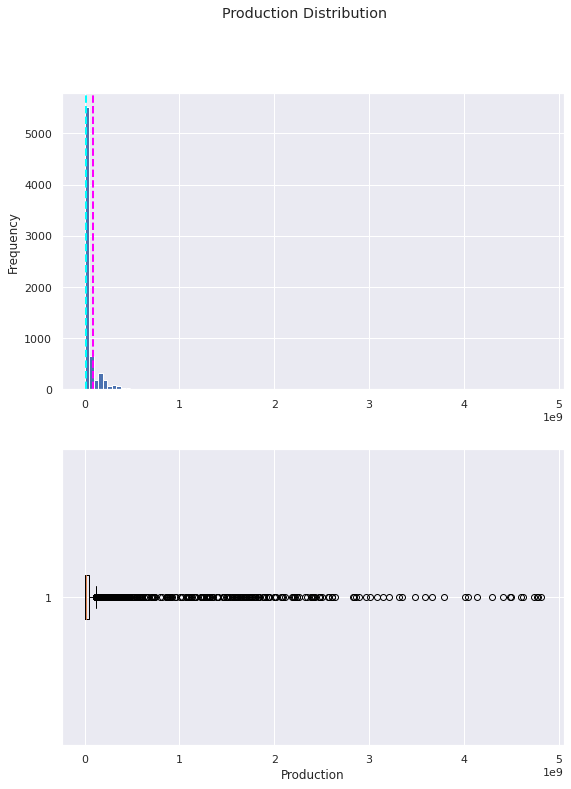

In [ ]:
#Distribution of Production
# Get the label column
label = Food_Security_dataset['Food_Production_tonnes']


# Create a figure for 2 subplots (2 rows, 1 column)
fig, ax = plt.subplots(2, 1, figsize = (9,12))

# Plot the histogram   
ax[0].hist(label, bins=100)
ax[0].set_ylabel('Frequency')

# Add lines for the mean, median, and mode
ax[0].axvline(label.mean(), color='magenta', linestyle='dashed', linewidth=2)
ax[0].axvline(label.median(), color='cyan', linestyle='dashed', linewidth=2)

# Plot the boxplot   
ax[1].boxplot(label, vert=False)
ax[1].set_xlabel('Production')

# Add a title to the Figure
fig.suptitle('Production Distribution')

# Show the figure
fig.show()

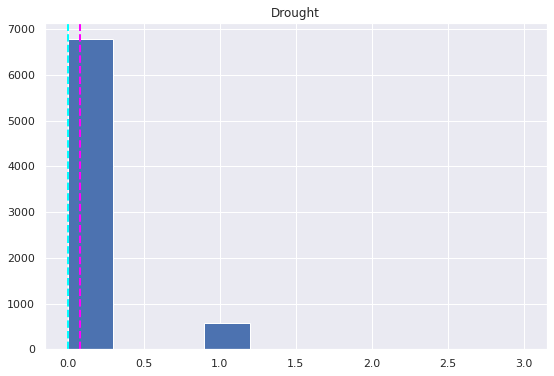

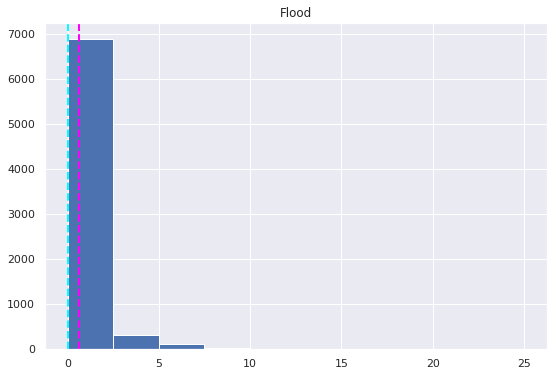

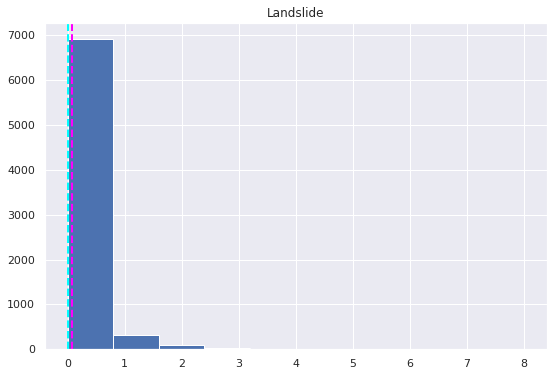

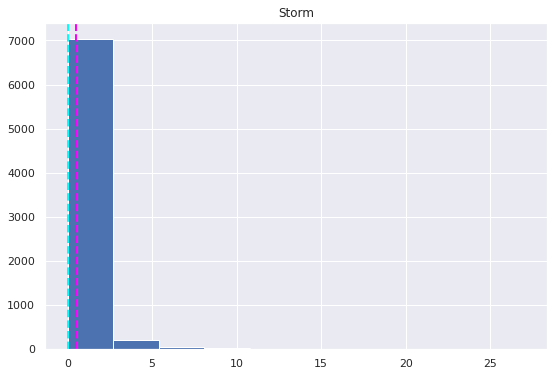

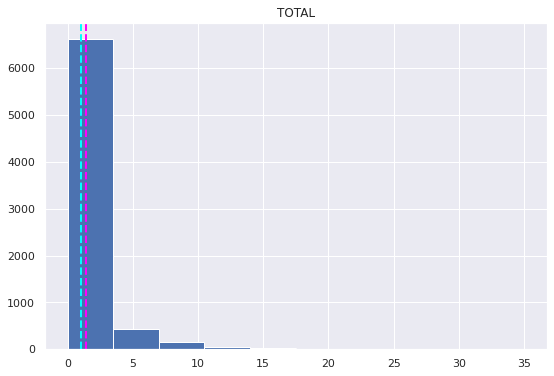

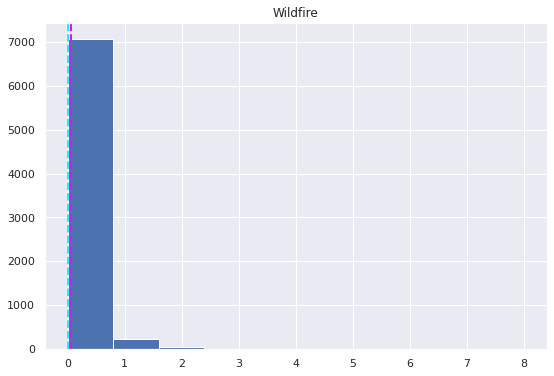

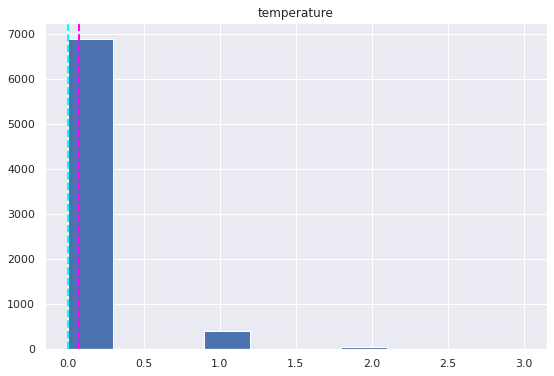

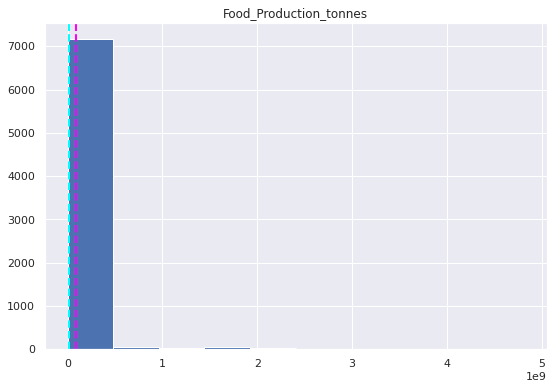

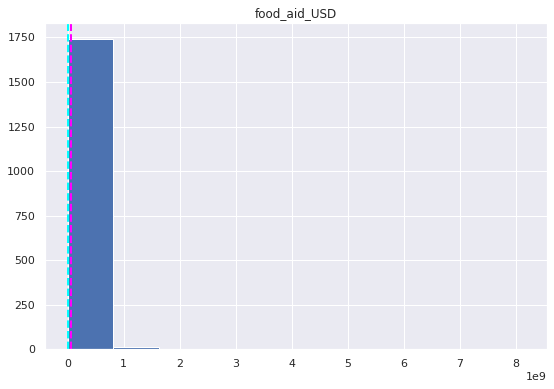

In [ ]:
# Plot a histogram for each numeric feature
numeric_features = ['Drought',	'Flood',	'Landslide',	'Storm',	'TOTAL',	'Wildfire',	'temperature',	'Food_Production_tonnes',	'food_aid_USD']
for col in numeric_features:
    fig = plt.figure(figsize=(9, 6))
    ax = fig.gca()
    feature = Food_Security_dataset[col]
    feature.hist(bins=10, ax = ax)
    ax.axvline(feature.mean(), color='magenta', linestyle='dashed', linewidth=2)
    ax.axvline(feature.median(), color='cyan', linestyle='dashed', linewidth=2)
    ax.set_title(col)
plt.show()

The numeric features seem to be more skewed to the right. We have a lot of zeroes in the data indicating that disastors are less frequent.

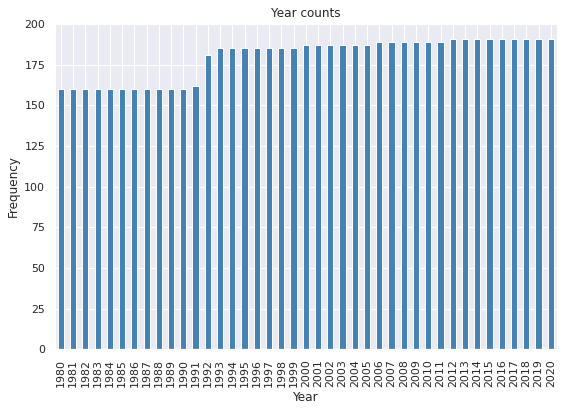

In [ ]:
# plot a bar plot for the year feature count
counts = Food_Security_dataset["Year"].value_counts().sort_index()
fig = plt.figure(figsize=(9, 6))
ax = fig.gca()
counts.plot.bar(ax = ax, color='steelblue')
ax.set_title('Year counts')
ax.set_xlabel('Year') 
ax.set_ylabel("Frequency")
plt.show()

Year shows a uniform distribution. However, there is a step from 1980-1991 to 1992-2020. This is indicating the number of rows was the same for period 1980-1991, then the rows increase in 1992 and roughly stays the same to 2020.

## Scatterplots for the numeric features as well as correlation statistics to quantify their apparent relationship

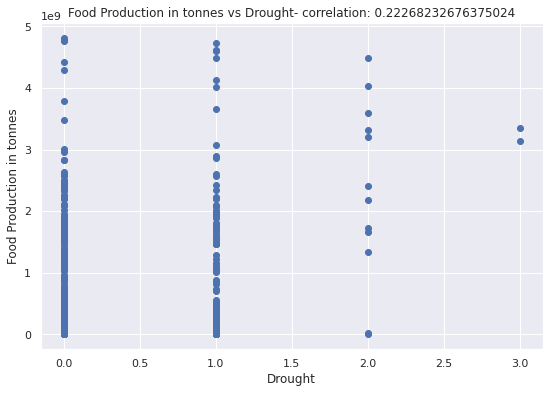

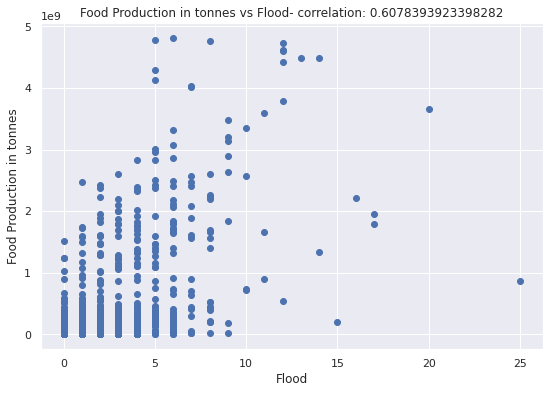

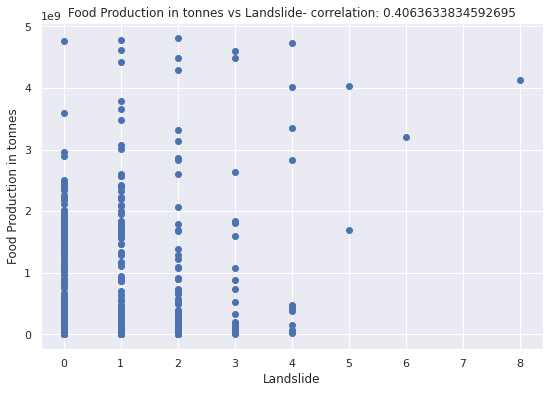

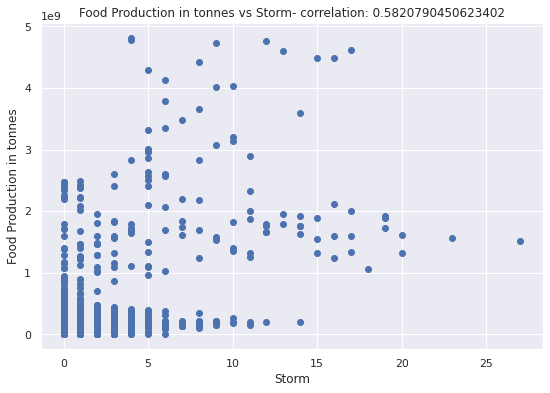

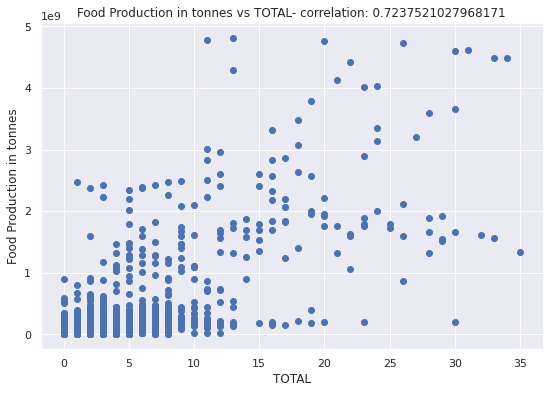

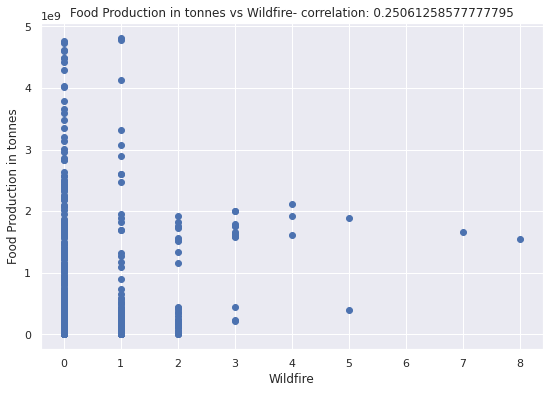

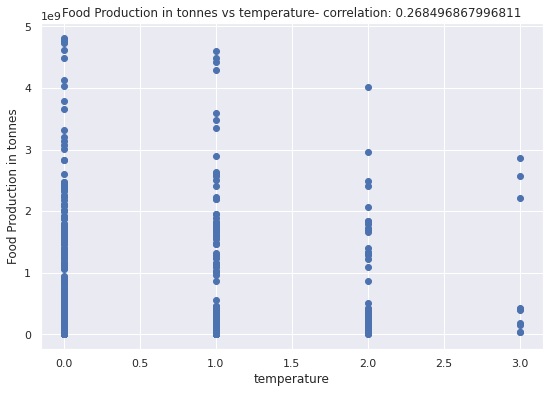

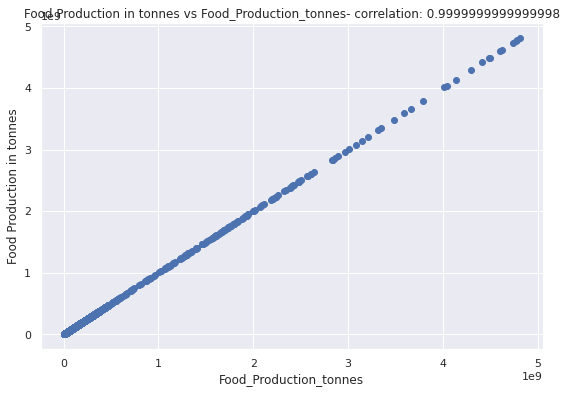

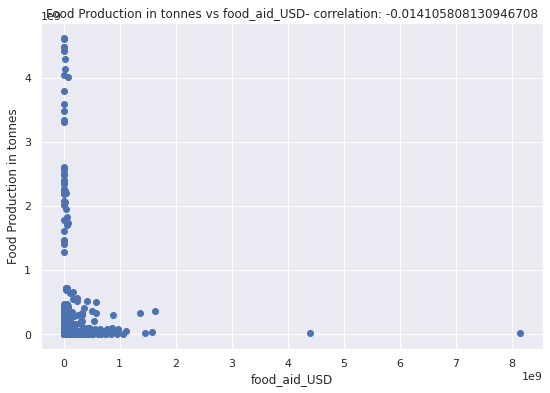

In [ ]:
for col in numeric_features:
    fig = plt.figure(figsize=(9, 6))
    ax = fig.gca()
    feature = Food_Security_dataset[col]
    label = Food_Security_dataset['Food_Production_tonnes']
    correlation = feature.corr(label)
    plt.scatter(x=feature, y=label)
    plt.xlabel(col)
    plt.ylabel('Food Production in tonnes')
    ax.set_title('Food Production in tonnes vs ' + col + '- correlation: ' + str(correlation))
plt.show()

From a close look, the scatter plots for Flood, Storm and Total gives us a vague diagonal trend showing that higher production coincide with higher numbers of Floods and Storms. Their correlation values are also over 0.5. The rest of the features have correlation less than 0.5 and food aid has a negative correlation, indicating that less food air occur when food production is high.